In [1]:
from typing import List

import polars as pl
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


def get_ozon_link(ids):
    for el in ids:
        print(f'https://www.ozon.ru/product/{el}')

# План семинара

1. Вспомним прошлые семинары
2. Мemory-based подходы
3. Мodel-based подходы

# Загрузим данные

In [2]:
product_info = pl.read_parquet('product_information_full')
product_info

product_id,name,brand,type,category_id,category_name
i64,str,str,str,i32,str
160839072,"""CeraVe Смягчающий крем для сух…","""CeraVe""","""Гель для ухода за кожей""",38,"""Сыворотки для лица"""
161689127,"""Yves Rocher / Ив Роше / Увлажн…","""Yves Rocher France""","""Гель для ухода за кожей""",38,"""Сыворотки для лица"""
221508445,"""Bioderma Эликсир для ухода за …","""Bioderma""","""Эликсир для ухода за кожей""",38,"""Сыворотки для лица"""
309017861,"""ART&FACT. / Сыворотка для лица…","""ART&FACT.""","""Сыворотка для лица""",38,"""Сыворотки для лица"""
793710195,"""Breylee Сыворотка для лица Ант…","""Breylee""","""Сыворотка для лица""",38,"""Сыворотки для лица"""
…,…,…,…,…,…
1154315599,"""Сушилка для овощей и фруктов 3…","""Великие реки""","""Дегидратор""",284,"""Сушилки для овощей"""
1196912369,"""GFGRIL Электрическая сушилка д…","""GFGRIL""","""Дегидратор""",284,"""Сушилки для овощей"""
1255681315,"""Дегидратор сушилка для овощей …","""Marta""","""Дегидратор""",284,"""Сушилки для овощей"""


In [3]:
user_actions_sample = pl.read_parquet('user_actions_full_sample_1_000_000')
user_actions_sample

user_id,timestamp,action_type,widget_name,search_query,product_id,page_product_id
i32,datetime[ns],str,str,str,f64,f64
5191333,2024-03-20 11:04:06,"""view""","""search_catalog_listing""",null,9.23442542e8,null
3741045,2024-06-27 18:39:09,"""view""","""search_catalog_listing""","""печенье""",6.18168589e8,null
5736030,2024-03-08 14:50:14,"""view""","""search_catalog_listing""",null,1.2156e9,null
2173455,2024-04-03 12:57:27,"""view""","""recoms_fresh_personal""",null,1.46227155e8,null
9569113,2024-07-26 01:49:36,"""view""","""search_catalog_listing""",null,1.0800e9,null
…,…,…,…,…,…,…
3795880,2024-04-09 18:01:25,"""view""","""recoms_fresh_personal""",null,5.01074615e8,null
6916747,2024-04-26 14:46:01,"""view""","""search_catalog_listing""",null,1.43294378e8,null
2346229,2024-06-28 17:16:12,"""view""","""recoms_fresh_personal""",null,4.28674301e8,null


In [4]:
(
    user_actions_sample
    .group_by('action_type')
    .len()
    .sort('len', descending=True)
)

action_type,len
str,u32
"""view""",952219
"""to_cart""",14551
"""search""",14079
"""click""",12165
"""order""",6241
"""favorite""",745


In [5]:
train = pl.read_parquet('train_orders')
test = pl.read_parquet('test_orders')

# уберем пакеты, которые нашли на первом семинаре
train = (
    train
    .filter(pl.col('product_id') != 519413018)
    .filter(pl.col('product_id') != 576985723)
    
)
test = (
    test
    .filter(pl.col('product_id') != 519413018)
    .filter(pl.col('product_id') != 576985723)
)

train.shape, test.shape

((19592465, 3), (8253307, 3))

In [6]:
# оставим меньше данных, чтобы быстрее считалось
train = (
    train
    .filter(pl.col('user_id') % 100 == 0)
#     .sample(n=100_000, seed=0)
)
test = (
    test
    .filter(pl.col('user_id') % 100 == 0)
#      .sample(n=10_000, seed=0)
)

train.shape, test.shape

((189713, 3), (82745, 3))

In [7]:
train

user_id,product_id,date
i32,i64,date
338900,174306600,2024-03-21
4408100,519493273,2024-04-08
2338900,365806931,2024-04-27
2358800,146763552,2024-06-10
2657500,704873725,2024-06-21
…,…,…
8630900,235129952,2024-03-28
395800,160572085,2024-06-07
7798100,672960189,2024-05-26


In [8]:
train.select('user_id').unique().count(), train.select('product_id').unique().count()

(shape: (1, 1)
 ┌─────────┐
 │ user_id │
 │ ---     │
 │ u32     │
 ╞═════════╡
 │ 10261   │
 └─────────┘,
 shape: (1, 1)
 ┌────────────┐
 │ product_id │
 │ ---        │
 │ u32        │
 ╞════════════╡
 │ 16451      │
 └────────────┘)

In [9]:
test.select('user_id').unique().count(), test.select('product_id').unique().count()

(shape: (1, 1)
 ┌─────────┐
 │ user_id │
 │ ---     │
 │ u32     │
 ╞═════════╡
 │ 6570    │
 └─────────┘,
 shape: (1, 1)
 ┌────────────┐
 │ product_id │
 │ ---        │
 │ u32        │
 ╞════════════╡
 │ 12436      │
 └────────────┘)

## Вспомним методы с первого семинара

### Рандомные рекомендации

In [10]:
DEFAULT_USER = 0
DEFAULT_TOP_K = 10

class Random:
    def __init__(self, is_uniform: bool = True, seed: int = 0):
        self.seed = seed
        self.is_uniform = is_uniform
        self.all_ids = None
        self.p = None
    
    def fit(self, data: pl.DataFrame, id_name: str = 'product_id'):
        self.all_ids = data[id_name].unique().to_list()
        if self.is_uniform:
            self.p = [1 / len(self.all_ids)] * len(self.all_ids)
        else:
            self.p = (
                data
                .group_by(id_name)
                .len()
                .with_columns(
                    (pl.col('len') / data.shape[0]).alias('p'),
                )
            )['p'].to_list()
        
    def predict(
        self,
        user_id: int = DEFAULT_USER,
        top_k: int = DEFAULT_TOP_K,
        seed_per_user: bool = True
    ) -> List[int]:
        seed = self.seed
        if seed_per_user:
            seed += user_id
        np.random.seed(seed)
        return np.random.choice(self.all_ids, size=top_k, replace=False, p=self.p)
        

### Топ популярных

In [11]:
class TopPopular:
    def __init__(self):
        self.sort_data = None
        self.id_name = None
    
    def fit(self, data: pl.DataFrame, id_name: str = 'product_id'):
        self.sort_data = (
            data
            .group_by(id_name)
            .len()
            .sort('len', descending=True)
        )
        self.id_name = id_name
        
    def predict(self, user_id: int = DEFAULT_USER, top_k: int = DEFAULT_TOP_K) -> List[int]:
        return self.sort_data.limit(top_k)[self.id_name].to_list()
        

In [12]:
tp = TopPopular()
tp.fit(train)

ids = tp.predict()
print(ids)
get_ozon_link(ids)

[148481523, 143259875, 398644623, 356292677, 135653559, 146215073, 266528732, 398644622, 142120588, 261375234]
https://www.ozon.ru/product/148481523
https://www.ozon.ru/product/143259875
https://www.ozon.ru/product/398644623
https://www.ozon.ru/product/356292677
https://www.ozon.ru/product/135653559
https://www.ozon.ru/product/146215073
https://www.ozon.ru/product/266528732
https://www.ozon.ru/product/398644622
https://www.ozon.ru/product/142120588
https://www.ozon.ru/product/261375234


###  Персональный топ популярных

In [13]:
class PersonalTopPopular:
    def __init__(self):
        self.sort_data = None
        self.id_name = None
        self.user_id = None
    
    def fit(self, data: pl.DataFrame, id_name: str = 'product_id', user_id: str = 'user_id'):
        self.sort_data = (
            data
            .group_by(user_id, id_name)
            .len()
            .sort('len', descending=True)
        )
        self.id_name = id_name
        self.user_id = user_id
        
    def predict(self, user_id: int = DEFAULT_USER, top_k: int = DEFAULT_TOP_K) -> List[int]:
        return (
            self.sort_data
            .filter(pl.col(self.user_id) == user_id)
            .limit(top_k)[self.id_name]
        ).to_list()

Возьмем какого-нибудь юзера из теста

In [14]:
print(test)

shape: (82_745, 3)
┌─────────┬────────────┬────────────┐
│ user_id ┆ product_id ┆ date       │
│ ---     ┆ ---        ┆ ---        │
│ i32     ┆ i64        ┆ date       │
╞═════════╪════════════╪════════════╡
│ 6075800 ┆ 1040744188 ┆ 2024-07-23 │
│ 9492700 ┆ 756423174  ┆ 2024-07-26 │
│ 6497200 ┆ 139192369  ┆ 2024-07-14 │
│ 2708500 ┆ 585936906  ┆ 2024-07-10 │
│ 1781500 ┆ 168666402  ┆ 2024-07-20 │
│ …       ┆ …          ┆ …          │
│ 1381200 ┆ 311405410  ┆ 2024-07-02 │
│ 3013300 ┆ 1052319329 ┆ 2024-07-15 │
│ 5245500 ┆ 145923205  ┆ 2024-07-01 │
│ 4408100 ┆ 145923199  ┆ 2024-07-03 │
│ 5135900 ┆ 676097300  ┆ 2024-07-20 │
└─────────┴────────────┴────────────┘


In [15]:
ptp = PersonalTopPopular()
ptp.fit(train)

ids = ptp.predict(user_id=4115173, top_k=10)
get_ozon_link(ids)

### Смешаем персональный топ популярных и общий

In [16]:
class PersonalTopPopularV2:
    def __init__(self, top_popular: TopPopular, personal_top_popular: PersonalTopPopular):
        self.top_popular = top_popular
        self.personal_top_popular = personal_top_popular
    
    def fit(self, data: pl.DataFrame, id_name: str = 'product_id', user_id: str = 'user_id'):
        self.top_popular.fit(data, id_name)
        self.personal_top_popular.fit(data, id_name, user_id)
        
    def predict(self, user_id: int = DEFAULT_USER, top_k: int = DEFAULT_TOP_K) -> List[int]:
        recs = []
        pers_top = self.personal_top_popular.predict(user_id, top_k)
        if len(pers_top) < top_k:
            top = self.top_popular.predict(user_id, top_k - len(pers_top))
            recs = pers_top + top
        else:
            recs = pers_top
        return recs

In [17]:
tp = TopPopular()
ptp = PersonalTopPopular()

ptp_v2 = PersonalTopPopularV2(top_popular=tp, personal_top_popular=ptp)
ptp_v2.fit(train)

In [18]:
ptp_v2.top_popular.sort_data

product_id,len
i64,u32
148481523,1384
143259875,696
398644623,674
356292677,640
135653559,604
…,…
810954369,1
985296295,1
688374048,1


### Вспомним метрики

In [19]:
# precision recall
def calc_pr_metrics(data, recs_column: str, top_k: int = DEFAULT_TOP_K):
    metrics = (
        data
        .select('user_id', 'ids', recs_column)
        .with_columns([
            pl.col('ids').list.set_intersection(pl.col(recs_column)).alias(f'relevant_in_{recs_column}')
        ])
        .with_columns([
            pl.col(f'relevant_in_{recs_column}').list.len().alias('len1'),
            pl.col(recs_column).list.len().alias('len2'),
            pl.col('ids').list.len().alias('len3')
        ])
        .with_columns([
            (pl.col('len1') / pl.col('len3')).alias('recall'),
            (pl.col('len1') / top_k).alias('precision'),
        ])
        .fill_nan(0)
        .select(
            pl.mean('recall').alias('recall'),
            pl.mean('precision').alias('precision')
        )
    )
    return metrics

In [20]:
sample_users = (
    test
    .group_by('user_id')
    .agg(
        pl.col("product_id").unique().alias("ids")
    )
    .sample(n=1000, seed=0)
)

In [21]:
tp = TopPopular()
tp.fit(train)

rn_uniform = Random(is_uniform=True)
rn_uniform.fit(train)

rn = Random(is_uniform=False)
rn.fit(train)

ptp = PersonalTopPopular()
ptp.fit(train)

ptp_v2 = PersonalTopPopularV2(top_popular=TopPopular(), personal_top_popular=PersonalTopPopular())
ptp_v2.fit(train)

In [22]:
recommemd_sample_users = (
    sample_users
    .with_columns([
        pl.col('user_id').map_elements(
            lambda x: tp.predict(user_id=x, top_k=10),
            return_dtype=pl.List(pl.Int64)
        ).alias('tp_recs'),
        
        pl.col('user_id').map_elements(
            lambda x: rn_uniform.predict(user_id=x, top_k=10),
            return_dtype=pl.List(pl.Int64)
        ).alias('rn_uniform_recs'),
        
        pl.col('user_id').map_elements(
            lambda x: rn.predict(user_id=x, top_k=10),
            return_dtype=pl.List(pl.Int64)
        ).alias('rn_recs'),
        
        pl.col('user_id').map_elements(
            lambda x: ptp.predict(user_id=x, top_k=10),
            return_dtype=pl.List(pl.Int64)
        ).alias('ptp_recs'),
        
        pl.col('user_id').map_elements(
            lambda x: ptp_v2.predict(user_id=x, top_k=10),
            return_dtype=pl.List(pl.Int64)
        ).alias('ptp_v2_recs'),
        
    ])
)
recommemd_sample_users

user_id,ids,tp_recs,rn_uniform_recs,rn_recs,ptp_recs,ptp_v2_recs
i32,list[i64],list[i64],list[i64],list[i64],list[i64],list[i64]
8063800,"[142624178, 551600569, 551600580]","[148481523, 143259875, … 261375234]","[162270003, 714078364, … 420030672]","[356683327, 253771159, … 306026410]","[141817610, 901300428, … 31469838]","[901300428, 141817610, … 141861408]"
522600,"[136074027, 138235076, … 1539026789]","[148481523, 143259875, … 261375234]","[642726064, 146958306, … 144576552]","[142624188, 821661009, … 551600595]","[1124516137, 563577077, … 139184354]","[713490449, 1124516137, … 150030863]"
7011100,"[148001285, 266528732, 1480429980]","[148481523, 143259875, … 261375234]","[326125181, 845345697, … 930278029]","[325194329, 844539071, … 925414647]",[],"[148481523, 143259875, … 261375234]"
10220500,[636506536],"[148481523, 143259875, … 261375234]","[1176623025, 160055584, … 242510506]","[1583858815, 143321857, … 219990826]",[],"[148481523, 143259875, … 261375234]"
3908100,"[138860233, 141861488, … 997950025]","[148481523, 143259875, … 261375234]","[1269916346, 1077378953, … 1453901831]","[1094209982, 1353333268, … 146395505]",[],"[148481523, 143259875, … 261375234]"
…,…,…,…,…,…,…
8409400,"[135507648, 141838275, … 538184648]","[148481523, 143259875, … 261375234]","[220188988, 1077612555, … 1423835244]","[212350019, 1074761658, … 1422257621]",[],"[148481523, 143259875, … 261375234]"
3089600,[245351975],"[148481523, 143259875, … 261375234]","[280658454, 160572002, … 446876422]","[281051417, 160542230, … 414758478]",[],"[148481523, 143259875, … 261375234]"
9476600,"[146215073, 162288229, … 539878217]","[148481523, 143259875, … 261375234]","[148234044, 578363564, … 466991822]","[147518904, 563280243, … 445947125]",[],"[148481523, 143259875, … 261375234]"


In [23]:
interactions = (
    recommemd_sample_users
    .select('user_id', pl.col('ids').alias('item_id'))
    .explode('item_id')
).to_pandas()

reco = (
    recommemd_sample_users
    .select('user_id', pl.col('ptp_recs').alias('item_id'), pl.lit(1).alias('rank'))
    .explode('item_id')
).to_pandas()

In [24]:
calc_pr_metrics(recommemd_sample_users, 'tp_recs')

recall,precision
f64,f64
0.017945,0.0291


In [25]:
calc_pr_metrics(recommemd_sample_users, 'ptp_recs')

recall,precision
f64,f64
0.082001,0.0847


In [26]:
calc_pr_metrics(recommemd_sample_users, 'ptp_v2_recs')

recall,precision
f64,f64
0.092013,0.0958


## Рассмотрим memory-based подход
### EASE

Модель EASE (Embarrassingly Shallow Autoencoder) представляет собой интересный подход к рекомендациям, основанный на принципах глубокого обучения, но при этом старается сохранить простоту в архитектуре. В отличие от сложных нейронных сетей, EASE использует упрощённую структуру, что делает ее более легковесной и устойчивой к переобучению.

### Обзор модели EASE

Основной идеей модели EASE является использование автокодировщиков для создания представлений пользователей и объектов на основе взаимодействий. Модель фокусируется на использовании данных рейтингов для генерации предсказаний. Она применяет метод наименьших квадратов (least squares) для обучения, что позволяет вычислять параметры модели в закрытой форме, обеспечивая устойчивость и простоту.


#### Преимущества и недостатки

Модель EASE обладает рядом преимуществ. Во-первых, ее простота делает обучение и интерпретацию результатов более доступными, особенно в средах, где объяснение рекомендаций является важным. Во-вторых, благодаря "поверхностной" структуре, EASE менее подвержена переобучению по сравнению с более сложными подходами, такие как глубокие нейронные сети.

Однако у модели есть и ограничения. Очевидным минусом является то, что она может не справляться с очень сложными паттернами взаимодействий между пользователями и объектами, что может привести к более низкой точности предсказаний по сравнению с более продвинутыми методами. Также EASE, как правило, требует достаточно много взаимодействий для успешного обучения модели.


Модель заключается в минимизации следующей функции:

$$
\begin{cases} 
\min_{B} ||X - XB||_{F}^{2} + \lambda \cdot ||B||_{F}^{2} \\ 
\text{diag}(B) = 0 
\end{cases}
$$

где:
- $X$ — матрица взаимодействий,
- $B$ — матрица весов, которую необходимо найти,
- $||X - XB||_{F}$ — норма Фробениуса,
- $\lambda$ — регуляризационный член для предотвращения переобучения.


Алгоритм включает следующие шаги:

1. Определить $G = X \cdot X^{T}$.
2. Добавить $\lambda$ к диагональным элементам $G$.
3. Найти обратную матрицу $G^{-1}$.
4. $B = G^{-1} \cdot \text{diag}(G^{-1})$, где $\text{diag}(G^{-1})$ — массив диагональных элементов.
5. Установить все элементы диагонали $B$ равными нулю. 



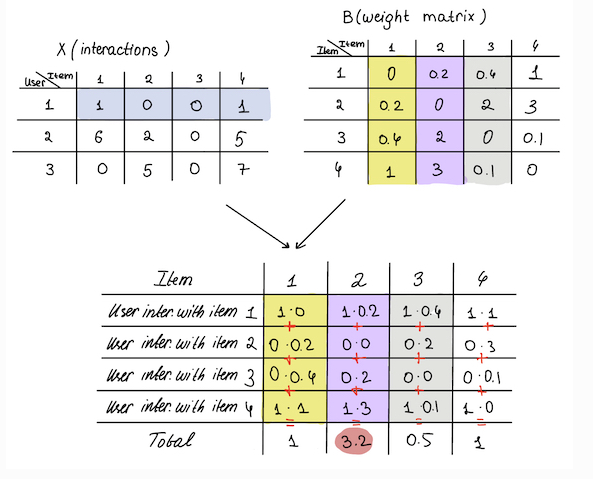

In [27]:
from rectools.models import EASEModel
from rectools.dataset import Dataset

In [28]:
train

user_id,product_id,date
i32,i64,date
338900,174306600,2024-03-21
4408100,519493273,2024-04-08
2338900,365806931,2024-04-27
2358800,146763552,2024-06-10
2657500,704873725,2024-06-21
…,…,…
8630900,235129952,2024-03-28
395800,160572085,2024-06-07
7798100,672960189,2024-05-26


In [29]:
train_interactions = (
    train
    .select(
        'user_id', 
        pl.col('product_id').alias('item_id'),
        pl.col('date').alias('datetime'),
        pl.lit(1).alias('weight')
    )
    .to_pandas()
)

In [30]:
dataset = Dataset.construct(
    interactions_df=train_interactions
)

In [31]:
%%time
model = EASEModel(regularization=500)
model.fit(dataset);

CPU times: user 7min 50s, sys: 12.3 s, total: 8min 3s
Wall time: 1min 23s


In [72]:
train.select('user_id').unique().count()

user_id
u32
10261


Посмотрим для какого множества пользователей сможем сделать предсказание

In [32]:
test_users = (
    recommemd_sample_users
    .join(train.select('user_id').unique(), 'user_id', 'inner')
    .select('user_id').unique().to_numpy().flatten()
)
len(test_users)

522

In [33]:
recos = model.recommend(
    users=test_users,
    dataset=dataset,
    k=10,
    filter_viewed=False,
)


In [35]:
recos = pl.DataFrame(recos)
recos = recos.group_by('user_id').agg(pl.col('item_id').alias('ease_recs')).sort('user_id')
recos

user_id,ease_recs
i32,list[i64]
32000,"[146763548, 1046198056, … 695659551]"
41300,"[923442561, 163600536, … 864376721]"
59900,"[326522570, 149262631, … 140800365]"
80300,"[232917893, 196962654, … 1074808936]"
101200,"[487809905, 750579819, … 669835829]"
…,…
11100600,"[266528732, 148590542, … 913957970]"
11130600,"[160571964, 398644622, … 168328427]"
11142200,"[145923211, 145081637, … 1032351794]"


In [36]:
recommemd_sample_users_with_ease = (
    recommemd_sample_users
    .join(
        recos,
        on='user_id',
        how='left'
    )
    
)
recommemd_sample_users_with_ease.head(3)

user_id,ids,tp_recs,rn_uniform_recs,rn_recs,ptp_recs,ptp_v2_recs,ease_recs
i32,list[i64],list[i64],list[i64],list[i64],list[i64],list[i64],list[i64]
8063800,"[142624178, 551600569, 551600580]","[148481523, 143259875, … 261375234]","[162270003, 714078364, … 420030672]","[356683327, 253771159, … 306026410]","[141817610, 901300428, … 31469838]","[901300428, 141817610, … 141861408]","[695659542, 138860208, … 600850741]"
522600,"[136074027, 138235076, … 1539026789]","[148481523, 143259875, … 261375234]","[642726064, 146958306, … 144576552]","[142624188, 821661009, … 551600595]","[1124516137, 563577077, … 139184354]","[713490449, 1124516137, … 150030863]","[139864792, 142624188, … 142624185]"
7011100,"[148001285, 266528732, 1480429980]","[148481523, 143259875, … 261375234]","[326125181, 845345697, … 930278029]","[325194329, 844539071, … 925414647]",[],"[148481523, 143259875, … 261375234]",null


Сравним метрики с прошлыми подходами

In [37]:
calc_pr_metrics(recommemd_sample_users_with_ease, 'ease_recs')

recall,precision
f64,f64
0.035868,0.0545


In [38]:
calc_pr_metrics(recommemd_sample_users_with_ease, 'ptp_v2_recs')

recall,precision
f64,f64
0.092013,0.0958


In [39]:
calc_pr_metrics(recommemd_sample_users_with_ease, 'rn_recs')

recall,precision
f64,f64
0.000376,0.0004


In [40]:
recommemd_sample_users_with_ease.select('user_id').unique().count()

user_id
u32
1000


## Model based подходы
Можем ли обучить обе матрицы сразу?

In [41]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, SVD, CoClustering
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.preprocessing import LabelEncoder


In [42]:
train_ratings = (
    train
    .select('user_id', 'product_id', pl.lit(1).alias('rating'))
    .to_pandas()
)
train_ratings

,user_id,product_id,rating
0,338900,174306600,1
1,4408100,519493273,1
2,2338900,365806931,1
3,2358800,146763552,1
4,2657500,704873725,1
...,...,...,...
189708,8630900,235129952,1
189709,395800,160572085,1
189710,7798100,672960189,1
189711,2739900,326522570,1


In [43]:
test_ratings = (
    test
    .select('user_id', 'product_id', pl.lit(1).alias('rating'))
    .to_pandas()
)
test_ratings

,user_id,product_id,rating
0,6075800,1040744188,1
1,9492700,756423174,1
2,6497200,139192369,1
3,2708500,585936906,1
4,1781500,168666402,1
...,...,...,...
82740,1381200,311405410,1
82741,3013300,1052319329,1
82742,5245500,145923205,1
82743,4408100,145923199,1


In [44]:
n_item = train_ratings.product_id.nunique() #16451
n_user = train_ratings.user_id.nunique() # 10261

embedding_size = 10
lr = 0.001
reg = 0.01

In [45]:
user_label_encoder = LabelEncoder()
item_label_encoder = LabelEncoder()

train_ratings['user_id'] = user_label_encoder.fit_transform(train_ratings['user_id'])
train_ratings['product_id'] = item_label_encoder.fit_transform(train_ratings['product_id'])

user_ids = torch.LongTensor(train_ratings['user_id'].values)
item_ids = torch.LongTensor(train_ratings['product_id'].values)
user_ratings = torch.FloatTensor(train_ratings['rating'].values)

In [46]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_user, n_item, embedding_size):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(n_user, embedding_size)
        self.item_embedding = nn.Embedding(n_item, embedding_size)
        self.user_bias_embedding = nn.Embedding(n_user, 1)
        self.item_bias_embedding = nn.Embedding(n_item, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))

    def forward(self, user, item):
        u = self.user_embedding(user)
        m = self.item_embedding(item)
        u_bias = self.user_bias_embedding(user).squeeze()
        m_bias = self.item_bias_embedding(item).squeeze()
        predicted_rating = torch.sum(u * m, dim=1) + u_bias + m_bias + self.global_bias
        return predicted_rating

In [47]:
model = MatrixFactorization(n_user, n_item, embedding_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

In [48]:
batch_size = 16
n_epoch = 10

for epoch in range(n_epoch):
    for start in range(0, len(user_ratings) - batch_size, batch_size):
        end = start + batch_size
        user_batch = user_ids[start:end]
        item_batch = item_ids[start:end]
        rating_batch = user_ratings[start:end]

        optimizer.zero_grad()
        outputs = model(user_batch, item_batch)
        loss = criterion(outputs, rating_batch)
        loss.backward()
        optimizer.step()

    print("RMSE", torch.sqrt(loss).item())

# Access the embeddings
item_embeddings = model.item_embedding.weight.detach().numpy()

RMSE 0.004919832572340965
RMSE 0.005068871192634106
RMSE 0.005068913102149963
RMSE 0.005068980157375336
RMSE 0.005069031845778227
RMSE 0.005068977363407612
RMSE 0.0050689782947301865
RMSE 0.005069360136985779
RMSE 0.005068677477538586
RMSE 0.005068968515843153


Почему видим такие метрики?

## ALS

Итак, поставлена задача построения модели со скрытыми переменными (latent factor model) для коллаборативной фильтрации:

$$\sum_{u,i} (r_{ui} - \langle p_u, q_i \rangle)^2 \to \min_{P,Q}. $$

Напомним, что суммирование ведется по всем парам $(u, i),$ для которых известен рейтинг $r_{ui}$ (и только по ним), а $p_u, q_i$ – латентные представления пользователя $u$ и товара $i$ из соответствующих матрицы $P, Q$.

Подход ALS (Alternating Least Squares) решает задачу, попеременно фиксируя матрицы $P$ и $Q$, — оказывается, что, зафиксировав одну из матриц, можно выписать аналитическое решение задачи для другой.

$$\nabla_{p_u} \bigg[ \sum_{u,i} (r_{ui} - \langle p_u, q_i \rangle)^2 \bigg] = \sum_{i} 2(r_{ui} - \langle p_u, q_i \rangle)q_i = 0$$

Воспользовавшись тем, что $a^Tbc = cb^Ta$, получим
$$\sum_{i} r_{ui}q_i - \sum_i q_i q_i^T p_u = 0.$$
Тогда окончательно каждый столбец матрицы $P$ можно найти по формуле
$$p_u = \bigg( \sum_i q_i q_i^T\bigg)^{-1}\sum_ir_{ui}q_i \;\; \forall u,$$
аналогично для столбцов матрицы $Q$
$$q_i = \bigg( \sum_u p_u p_u^T\bigg)^{-1}\sum_ur_{ui}p_u \;\; \forall i.$$

Таким образом мы можем решать оптимизационную задачу, поочередно фиксируя одну из матриц $P$ или $Q$ и проводя оптимизацию по второй.

**Оригинальная статья (для explicit feedback):**

Bell, R.M. and Koren, Y., 2007, October. Scalable collaborative filtering with jointly derived neighborhood interpolation weights. In Seventh IEEE international conference on data mining (ICDM 2007) (pp. 43-52). IEEE.


### iALS


**Статья для implicit данных:**


Implicit feedback ALS:
* Hu, Y., Koren, Y. and Volinsky, C., 2008, December. Collaborative filtering for implicit feedback datasets. In 2008 Eighth IEEE international conference on data mining (pp. 263-272). Ieee. http://yifanhu.net/PUB/cf.pdf

**Особенности:**

1. Нет explicit данных (явных позитивных и отрицательных оценок). <br>
2. Много шума в данных.  <br>
3. Используются свои функции и метрики для оценки implicit feedback. Если в explicit $r_ui$ - это оценки предпочтений пользователя, то в implicit - это степень уверенности. <br>

Наша задача оптимизации в том, что мы стремимся минимизировать целевую функцию и найти
оптимальные $X$ и $Y$. В частности, мы стремимся минимизировать ошибку наименьших квадратов наблюдаемых оценок
(и упорядочить):

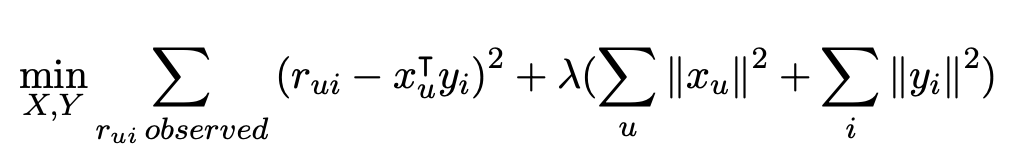  

Для implicit feedback:

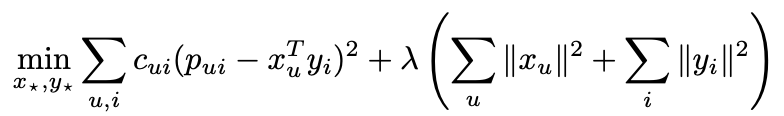  

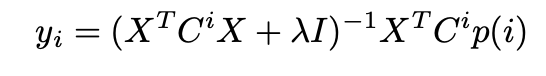


Авторы статьи вводят набор переменных, $c_ui$, которые измеряют нашу уверенность в наблюдении за $p_ui$. Чем больше значение наблюдения за пользовательским элементом, тем больше вы уверены в этом значении. Таким образом, у нас есть некоторая минимальная уверенность в $p_ui$ для каждой пары пользовательских элементов, но по мере того, как мы наблюдаем больше положительных предпочтений по паре пользователь-объект, наша уверенность в $p_ui$ = 1 соответственно возрастает. Скорость увеличения регулируется константой $\alpha$.

<img src='https://raw.githubusercontent.com/anamarina/RecSys_course/main/week2/images/als.png' width=700 height=500>



| Критерий | ALS  |  iALS | 
|---|---|---|
| Тип данных | Этот подход используется, когда у вас есть явные рейтинги или оценки, предоставленные пользователями для различных предметов. Например, пользователи могут оценивать фильмы по шкале от 1 до 5. |  Этот подход используется, когда у вас есть неявные сигналы взаимодействия между пользователями и предметами, такие как клики, просмотры, покупки или временные интервалы между действиями. |  
|
|Цель | Модель стремится точно предсказать явные рейтинги или оценки, которые пользователи могли бы дать предметам. | Модель стремится моделировать уровень уверенности или важности взаимодействия между пользователем и предметом, но не предсказывает явные рейтинги.|  
|
|Функции потерь| Обычно использует функцию потерь, такую как среднеквадратичная ошибка (MSE), для минимизации разницы между предсказанными и фактическими оценками. | Использует функцию потерь, которая учитывает уверенность в неявных взаимодействиях и стремится увеличить уверенность для более важных взаимодействий.| 
|
|Взвешивание| Не уделяет внимания взаимодействиям, которые не были явно оценены пользователями. Исключает информацию о неявных действиях. | Дополнительная параметризация. Учитывает все неявные действия, но с учетом их уверенности или веса, что позволяет модели учесть важность различных видов взаимодействий| 
|

Напишем небольшую обертку вокруг готовой реализации implicit als

In [50]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

from tqdm.auto import tqdm


class ImplicitModel:
    def __init__(self, model):
        self.model = model
        self.trained = False

    def fit(self, train_df: pd.DataFrame):
        self.item_encoder = LabelEncoder()
        self.user_encoder = LabelEncoder()
        self.item_encoder.fit(train_df.item_id)
        self.user_encoder.fit(train_df.user_id)

        self.train_ratings = self.encode_table(train_df, ["user_id", "item_id"])
        self.model.fit(self.train_ratings)
        self.trained = True

    def predict(self, test_df: pd.DataFrame, top_k: int = 100):
        if not self.trained:
            raise ValueError("Model is not fitted. Please, fit the model first")
        users_to_predict = test_df.user_id
        encoded_users = self.user_encoder.transform(users_to_predict)
        user_recs = self.model.recommend(
            encoded_users, self.train_ratings[encoded_users], N=top_k, filter_already_liked_items=True
        )[0]
        recs = [self.item_encoder.inverse_transform(x) for x in user_recs]
        return recs

    def encode_table(
        self,
        df: pd.DataFrame,
        axis_names: List[str],
    ) -> np.ndarray:
        user_ids = self.user_encoder.transform(df[axis_names[0]])
        item_ids = self.item_encoder.transform(df[axis_names[1]])

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        sparse = csr_matrix((np.ones(len(user_ids)), (user_ids, item_ids)), shape=matrix_shape, dtype=np.float32)

        return sparse

In [54]:
train_df = train_ratings[['user_id', 'product_id', 'rating']].rename(columns={'product_id': 'item_id'})
train_df

,user_id,item_id,rating
0,298,4680,1
1,4090,8751,1
2,2145,7669,1
3,2164,2693,1
4,2440,10530,1
...,...,...,...
189708,8004,5705,1
189709,361,4006,1
189710,7231,10244,1
189711,2520,7272,1


In [55]:
als = AlternatingLeastSquares(iterations=3, factors=32, regularization=0.01, calculate_training_loss=True)
als_recommender = ImplicitModel(als)
als_recommender.fit(train_df)

/Users/osinovskov/miniconda3/lib/python3.8/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/3 [00:00<?, ?it/s]

В домашнем задании сравним метрики